Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 19457124.51it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 658696.99it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2290310.11it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7852649.95it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



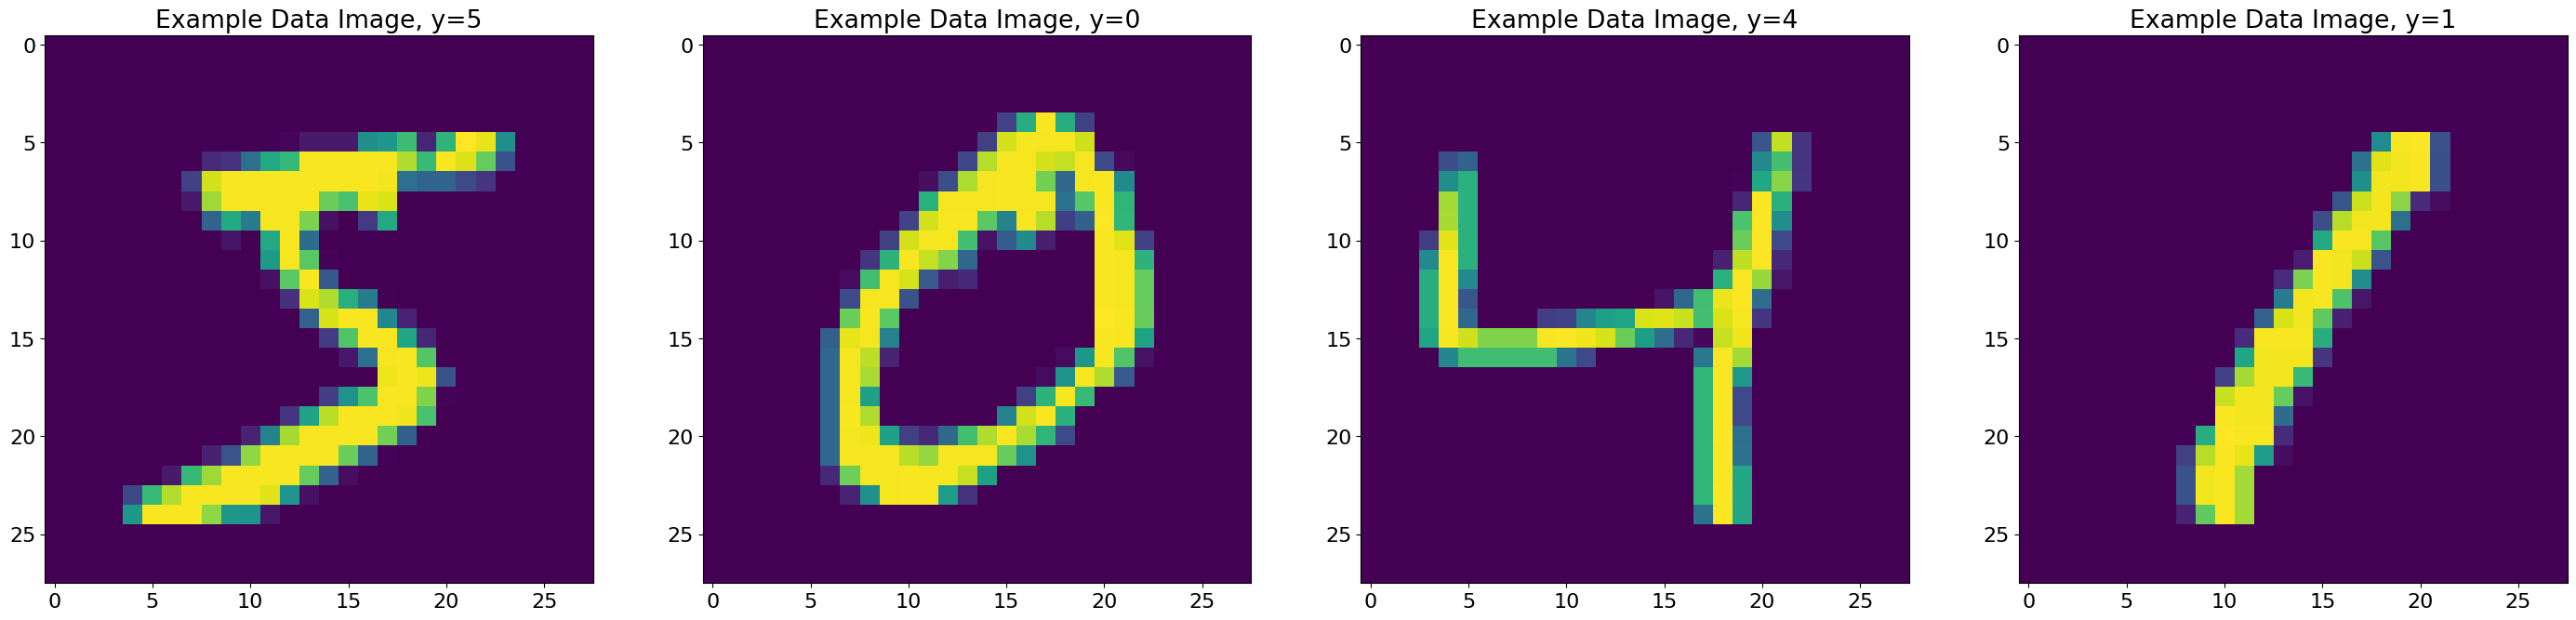

Device:  cpu
AutoencoderClassifier(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=256, bias=True)
  )
  (classifier): Linear(in_features=256, out_features=10, bias=True)
)
Epoch: 1/30... Train Loss: 0.4904... Train Accuracy: 0.8663... Val Loss: 0.2251... Val Accuracy: 0.9352... Time Taken: 21.5786 seconds
Epoch: 2/30... Train Loss: 0.1867... Train Accuracy: 0.9461... Val Loss: 0.1519... Val Accuracy: 0.9546... Time Taken: 19.4087 seconds
Epoch: 3/30... Train Loss: 0.1280... Train Accuracy: 0.9621... Val Loss: 0.1174... Val Accuracy: 0.9643... Time Taken: 20.2650 seconds
Epoch: 4/30... Train Loss: 0.0955... Train Accuracy: 0.9723... Val Loss: 0.0978... Val Accuracy: 0.9695... Time Taken: 19.9085 seconds
Epoch: 5/30... Train Loss: 0.0733... Train Accuracy: 0.9786... Val Loss: 0.0889

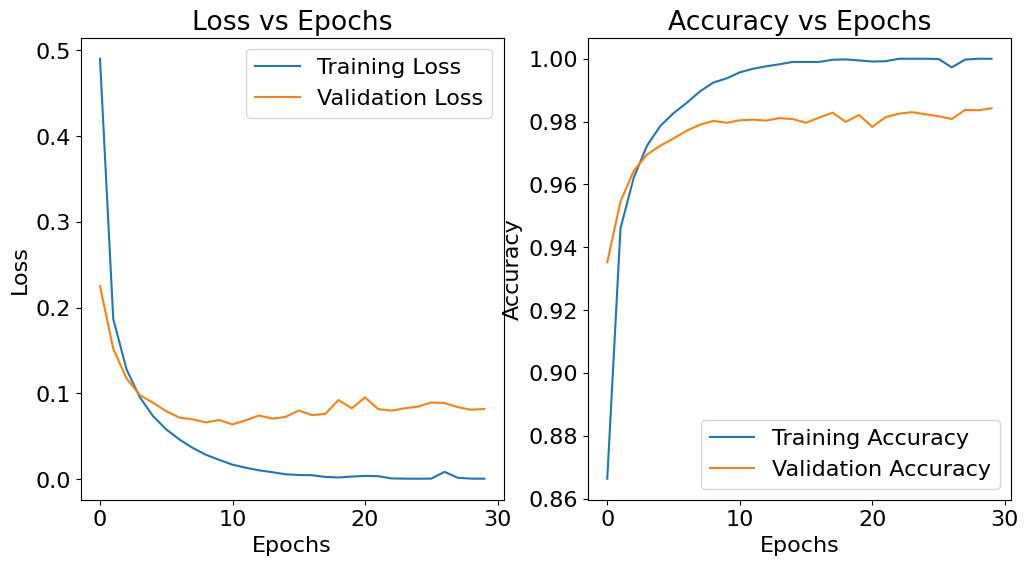

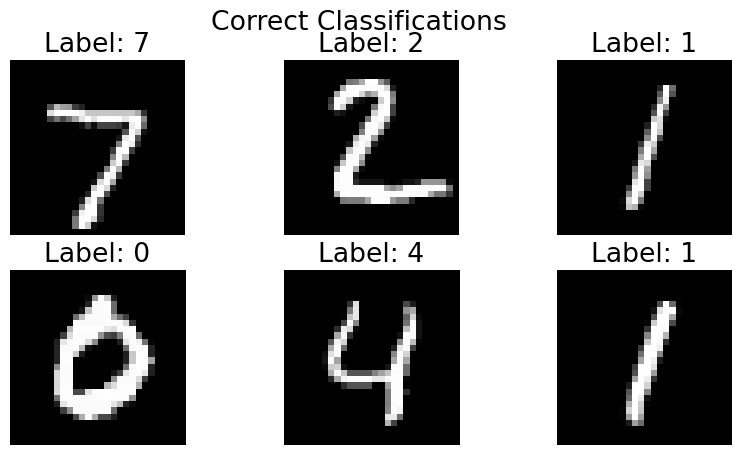

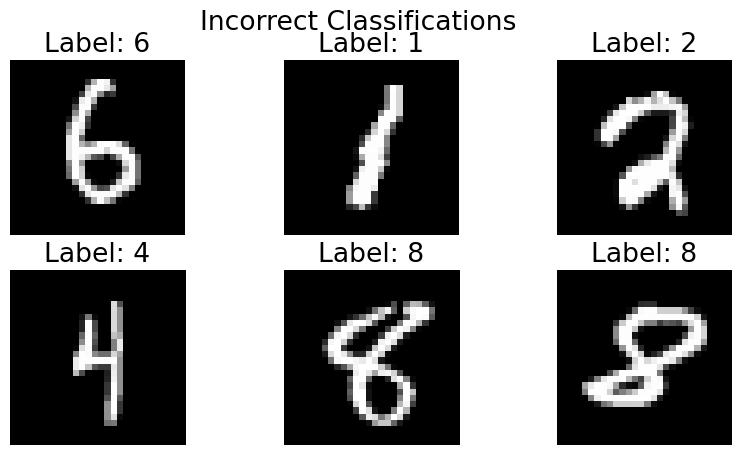

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix random seeds for reproducibility
seed = 73
torch.manual_seed(seed)
np.random.seed(seed)

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

# Load MNIST dataset
train_data = MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_data = MNIST('data', train=False, download=True, transform=transforms.ToTensor())

x_train = train_data.data.float() / 255
y_train = train_data.targets
x_test = test_data.data.float() / 255
y_test = test_data.targets

# Save as .npz
np.savez_compressed('data/mnist_train', a=x_train, b=y_train)
np.savez_compressed('data/mnist_test', a=x_test, b=y_test)

# Load MNIST data locally
train_data = np.load('data/mnist_train.npz')
x_train = torch.Tensor(train_data['a'])
y_train = torch.Tensor(train_data['b']).long()
n_classes = len(np.unique(y_train))

test_data = np.load('data/mnist_test.npz')
x_test = torch.Tensor(test_data['a'])
y_test = torch.Tensor(test_data['b']).long()

# Visualise data
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 4, figsize=(35, 35))
imx, imy = (28, 28)
labels = [0, 1, 2, 3]
for i, ax in enumerate(axes):
    visual = np.reshape(x_train[labels[i]], (imx, imy))
    ax.set_title("Example Data Image, y=" + str(int(y_train[labels[i]])))
    ax.imshow(visual, vmin=0, vmax=1)
plt.show()

class AutoencoderClassifier(nn.Module):
    def __init__(self, input_shape, output_shape, z_dim):
        super(AutoencoderClassifier, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.z_dim = z_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, z_dim)
        )

        # Classifier
        self.classifier = nn.Linear(z_dim, output_shape)

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        z = self.encoder(x_flat)
        return self.classifier(z)

# Hyperparameters
z_dim = 256
epochs = 30
batch_size = 128
learning_rate = 1e-4
decay_rate = 0.97

# Create DataLoader
train_dataset = data_utils.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = data_utils.TensorDataset(x_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Loss function: Cross Entropy Loss
def loss_function(y_pred, y):
    return F.cross_entropy(y_pred, y)

# Initialize AutoencoderClassifier
autoencoder_classifier = AutoencoderClassifier(np.prod(x_train[0].shape), n_classes, z_dim)

# Optimizer
optimizer = torch.optim.Adam(autoencoder_classifier.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

# Send to GPU if available
autoencoder_classifier.to(device)

print("Device: ", device)
print(autoencoder_classifier)

# Training
measures = defaultdict(list)
start_time = time.time()

# Put model into train mode
autoencoder_classifier.train()

for epoch in range(epochs):
    epoch_start_time = time.time()

    # Exponential decay of learning rate every 2 epochs
    if epoch % 2 == 0 and epoch > 0:
        scheduler.step()

    batch_loss = 0
    batch_accuracy = 0
    for _, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        # Zero accumulated gradients
        autoencoder_classifier.zero_grad()

        # Forward pass through AutoencoderClassifier
        y_pred = autoencoder_classifier(X)

        # Calculate loss
        loss = loss_function(y_pred, y)
        # Backpropagation: calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()

        # Save loss per batch
        batch_loss += loss.item() * X.size(0)
        # Save accuracy per batch
        y_pred = torch.argmax(y_pred, dim=1)
        batch_accuracy += int(torch.sum(y == y_pred))

    # Save losses per epoch
    measures['train_loss'].append(batch_loss / len(train_dataloader.dataset))
    # Save accuracy per epoch
    measures['train_accuracy'].append(batch_accuracy / len(train_dataloader.dataset))

    # Validation
    val_loss = 0
    val_accuracy = 0
    autoencoder_classifier.eval()
    with torch.no_grad():
        for _, (X, y) in enumerate(test_dataloader):
            X = X.to(device)
            y = y.to(device)

            y_pred = autoencoder_classifier(X)
            loss = loss_function(y_pred, y)

            val_loss += loss.item() * X.size(0)
            y_pred = torch.argmax(y_pred, dim=1)
            val_accuracy += int(torch.sum(y == y_pred))

    measures['val_loss'].append(val_loss / len(test_dataloader.dataset))
    measures['val_accuracy'].append(val_accuracy / len(test_dataloader.dataset))

    print(f"Epoch: {epoch + 1}/{epochs}...",
          f"Train Loss: {measures['train_loss'][-1]:.4f}...",
          f"Train Accuracy: {measures['train_accuracy'][-1]:.4f}...",
          f"Val Loss: {measures['val_loss'][-1]:.4f}...",
          f"Val Accuracy: {measures['val_accuracy'][-1]:.4f}...",
          f"Time Taken: {time.time() - epoch_start_time:.4f} seconds")

print(f"Total Time Taken: {time.time() - start_time:.4f} seconds")

# Plot metrics
def plot_metrics(measures):
    epochs = len(measures['train_loss'])

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), measures['train_loss'], label='Training Loss')
    plt.plot(range(epochs), measures['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), measures['train_accuracy'], label='Training Accuracy')
    plt.plot(range(epochs), measures['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')

    plt.show()

# Call the function after training
plot_metrics(measures)

# Evaluate and visualize correct and incorrect classifications
autoencoder_classifier.eval()
correct_indices = []
incorrect_indices = []

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        y_pred = autoencoder_classifier(X)
        y_pred = torch.argmax(y_pred, dim=1)

        correct_indices.extend((y_pred == y).nonzero(as_tuple=True)[0].tolist())
        incorrect_indices.extend((y_pred != y).nonzero(as_tuple=True)[0].tolist())

# Plot correct classifications
def plot_examples(data, indices, title):
    plt.figure(figsize=(10, 5))
    for i, index in enumerate(indices[:6]):
        plt.subplot(2, 3, i+1)
        plt.imshow(data[index].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title(f'Label: {y_test[index]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_examples(x_test, correct_indices, 'Correct Classifications')
plot_examples(x_test, incorrect_indices, 'Incorrect Classifications')
